# Offline classification model training

This notebook describe the CNN training for performing the gait representation (GEI) classification task. For replication purposes, is recommended to run this notebook on [Google Colab](https://colab.research.google.com/?hl=en) making use of the GPU runtime.

⚠️ When running this notebook, make sure you are using the same python version as the one used in the jetson nano device (3.6), where the model will be deployed. Also, make sure to install the same packages versions as the ones used in the jetson nano device. Otherwise, the model may not will be able to be accelerated and deployed in the Jetson Nano device.

In [1]:
!python3 --version

Python 3.6.13 :: Anaconda, Inc.


⚠️ Use TensorFlow 2.4.1, as it is the version that is compatible with the environment at the Jetson Nano device.

In [2]:
import tensorflow as tf

tensorflow_version = tf.__version__
print(tensorflow_version)

2.4.1


## Import libraries and pre-processing

In [60]:
from tensorflow import keras
from tensorflow.keras import regularizers
from sklearn.metrics import ConfusionMatrixDisplay
import tensorflow as tf
import seaborn as sns
import sklearn.metrics as metrics
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix


In [4]:
datagenerator = ImageDataGenerator(rescale = 1/255.,
                                   width_shift_range=0.01, # horizontal shift
                                   horizontal_flip=True, # horizontal flip
                                   validation_split=0.2) 

In [38]:
training_data = '../../datasets/OAKGait16/representations_training_dataset'


img_height = 220
img_width = 220
batch_size = 4

train_ds = datagenerator.flow_from_directory(
    training_data,
    color_mode='grayscale',
    class_mode = "categorical",
    target_size=(img_height, img_width),
    batch_size=batch_size,
    subset = "training"
)

val_ds = datagenerator.flow_from_directory(
    training_data,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    color_mode='grayscale',
    class_mode = "categorical",
    subset = "validation"
)

Found 1020 images belonging to 17 classes.
Found 255 images belonging to 17 classes.


In [39]:
classes = ['000','001','002','003','004','005','006','007','008','009','010','011','012','013','014','015','016']
print(classes)

['000', '001', '002', '003', '004', '005', '006', '007', '008', '009', '010', '011', '012', '013', '014', '015', '016']


In [40]:
def plotImages(images_arr):
  fig, axes = plt.subplots(1, 4, figsize = (10, 10))
  axes = axes.flatten()
  for img, ax in zip(images_arr, axes):
    ax.imshow(img[:,:,0], cmap='gray')
    ax.axis("off")
  plt.tight_layout()
  plt.show()

(4, 220, 220, 1)


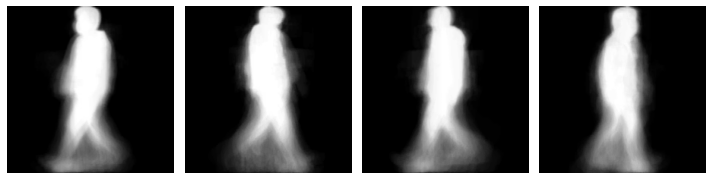

In [41]:
sample_training_images, _= next(iter(train_ds))
print(sample_training_images.shape)
plotImages(sample_training_images[:4])

## CNN model definition and training

In [42]:
model_cnn = keras.models.Sequential()

model_cnn.add(keras.layers.Conv2D(16, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(32, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same'))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(64, (3,3), padding='same', kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))

model_cnn.add(keras.layers.Conv2D(128, (3,3), padding='same', kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.MaxPooling2D((2,2)))


model_cnn.add(keras.layers.Flatten())
model_cnn.add(keras.layers.Dense(75, kernel_regularizer= regularizers.l2(1e-3)))
model_cnn.add(keras.layers.Activation(keras.layers.LeakyReLU()))
model_cnn.add(keras.layers.Dropout(0.50))
model_cnn.add(keras.layers.Dense(len(classes), activation = "softmax"))

model_cnn.build((None, 220, 220, 1))
model_cnn.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_25 (Conv2D)           (None, 220, 220, 16)      160       
_________________________________________________________________
activation_24 (Activation)   (None, 220, 220, 16)      0         
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 110, 110, 16)      0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 110, 110, 32)      4640      
_________________________________________________________________
activation_25 (Activation)   (None, 110, 110, 32)      0         
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 55, 55, 32)        0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 55, 55, 64)       

In [43]:
from tensorflow.keras.callbacks import Callback

class TrainingCallback(Callback):
  def on_epoch_end(self, epoch, logs = {}):
    if logs.get("val_accuracy") > 0.93:
      print("Achieved")
      self.model.stop_training = True

In [44]:
epochs = 25

optimizer = keras.optimizers.Adam(
    learning_rate=0.0001,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False,
    name="Adam",
)

callback = TrainingCallback()


model_cnn.compile(optimizer=optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
training_samples = train_ds.n
val_samples = val_ds.n
history_cnn = model_cnn.fit(
    train_ds,
    steps_per_epoch=training_samples // batch_size,
    epochs = epochs,
    callbacks = [callback],
    validation_data=val_ds,
    validation_steps=val_samples // batch_size,
)

Epoch 1/25
255/255 [==============================] - 36s 139ms/step - loss: 3.1128 - accuracy: 0.0604 - val_loss: 3.0540 - val_accuracy: 0.0595
Epoch 2/25
255/255 [==============================] - 34s 132ms/step - loss: 3.0414 - accuracy: 0.0518 - val_loss: 3.0028 - val_accuracy: 0.1587
Epoch 3/25
255/255 [==============================] - 32s 124ms/step - loss: 2.9962 - accuracy: 0.0890 - val_loss: 2.9359 - val_accuracy: 0.1230
Epoch 4/25
255/255 [==============================] - 32s 124ms/step - loss: 2.8999 - accuracy: 0.1291 - val_loss: 2.5100 - val_accuracy: 0.1905
Epoch 5/25
255/255 [==============================] - 31s 120ms/step - loss: 2.3749 - accuracy: 0.2867 - val_loss: 1.8825 - val_accuracy: 0.4484
Epoch 6/25
255/255 [==============================] - 31s 120ms/step - loss: 1.6206 - accuracy: 0.5542 - val_loss: 1.4116 - val_accuracy: 0.5714
Epoch 7/25
255/255 [==============================] - 30s 118ms/step - loss: 1.2503 - accuracy: 0.6498 - val_loss: 0.9211 - val_ac

In [52]:
def visualize_results(history):
    # Check if history contains the required keys
    required_keys = ['accuracy', 'loss', 'val_accuracy', 'val_loss']
    if not all(key in history.history for key in required_keys):
        raise ValueError('The history object is missing required keys.')

    epochs = range(1, len(history.history['accuracy']) + 1)
    fig, ax = plt.subplots(1, 2, figsize=(16, 9))

    # Plot training & validation accuracy
    ax[0].plot(epochs, history.history['accuracy'], 'b-', label="Training accuracy")
    ax[0].plot(epochs, history.history['val_accuracy'], 'r-', label="Validation accuracy")
    ax[0].set_title("Training & Validation Accuracy")
    ax[0].set_xlabel("Epochs")
    ax[0].set_ylabel("Accuracy")
    ax[0].legend()
    ax[0].grid(True)

    # Plot training & validation loss
    ax[1].plot(epochs, history.history['loss'], 'b-', label="Training Loss")
    ax[1].plot(epochs, history.history['val_loss'], 'r-', label="Validation Loss")
    ax[1].set_title("Training & Validation Loss")
    ax[1].set_xlabel("Epochs")
    ax[1].set_ylabel("Loss")
    ax[1].legend()
    ax[1].grid(True)

    plt.tight_layout()
    plt.show()


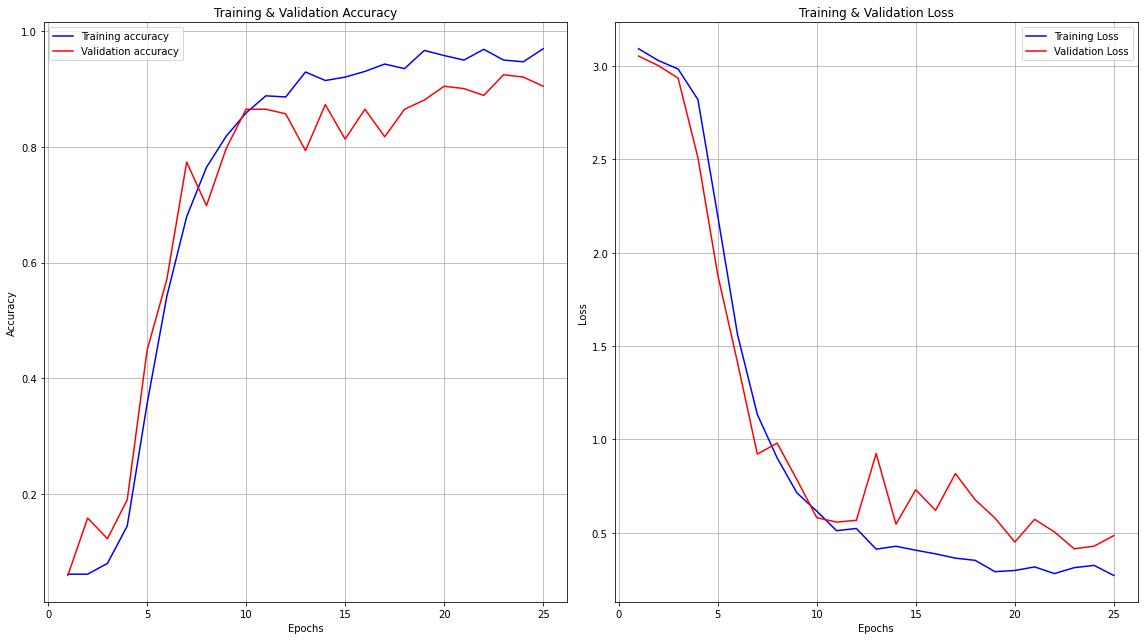

In [53]:
visualize_results(history_cnn)

<AxesSubplot:>

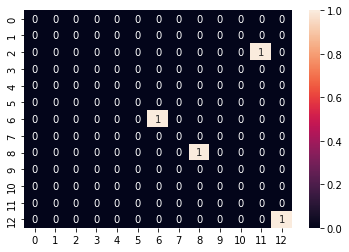

In [64]:
test_batch = []
for data in next(val_ds):
  test_batch.append(data)

image_batch = test_batch[0]
label_batch = test_batch[1] 

predictions = np.argmax(model_cnn.predict(image_batch), axis=1)
label_batch = np.argmax(label_batch, axis=1)
cf_matrix = tf.math.confusion_matrix(label_batch, predictions)
sns.heatmap(cf_matrix, annot=True)

In [68]:
model_acc = round(history_cnn.history['accuracy'][-1], 4)
model_loss = round(history_cnn.history['loss'][-1], 4)
model_val_acc = round(history_cnn.history['val_accuracy'][-1], 4)
model_val_loss = round(history_cnn.history['val_loss'][-1], 4)

model_cnn_path = f"cnn_gait_recognition_acc_{model_acc}_loss_{model_loss}_val_acc_{model_val_acc}_loss_acc_{model_val_loss}"

In [69]:
model_cnn.save(f'../../models/{model_cnn_path}')

INFO:tensorflow:Assets written to: ../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/assets


INFO:tensorflow:Assets written to: ../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/assets


In [72]:
!zip -r "../../{model_cnn_path}.zip" "../../models/{model_cnn_path}"

  adding: ../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/ (stored 0%)
  adding: ../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/variables/ (stored 0%)
  adding: ../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/variables/variables.index (deflated 68%)
  adding: ../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/variables/variables.data-00000-of-00001 (deflated 7%)
  adding: ../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/assets/ (stored 0%)
  adding: ../../models/cnn_gait_recognition_acc_0.9696_loss_0.2711_val_acc_0.9048_loss_acc_0.4846/saved_model.pb (deflated 90%)
